In [72]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

# Run all nodes interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Read weather data from json files & parse into DataFrame 

### Read weather data

In [265]:
weather_data = pd.DataFrame()
index_error_dates = []  # At least 1 day where node we're referencing doesn't exist - keeps track of the date(s) where this occurs
date = datetime.date(year = 2012, month = 1, day = 1)
while date < datetime.date(year = 2017, month = 12, day = 23):
    nextday = pd.Series()
    nextday.name = date
    nextday_df = pd.read_json('data/weather/Theewaterskloof_{0}.json'.format(str(date.strftime('%Y%m%d'))))
    try:
        for key, value in nextday_df['history']['dailysummary'][0].items():
            if not isinstance(value, dict):
                nextday[key] = value
        nextday = nextday.to_frame().transpose()
        weather_data = pd.concat([weather_data, nextday], axis = 0)
    except IndexError:
        index_error_dates.append(date.strftime('%Y-%m-%d'))
    date = date + datetime.timedelta(days = 1)

Convert index to date and numeric values to numeric types

In [264]:
weather_data.head()

,mindewpti,heatingdegreedaysnormal,precipi,gdegreedays,tornado,since1sepcoolingdegreedaysnormal,since1julsnowfalli,meanwindspdm,thunder,maxwspdi,...,monthtodatesnowfallm,monthtodatecoolingdegreedays,snowfallm,maxvisi,mintempm,minhumidity,since1sepheatingdegreedaysnormal,coolingdegreedaysnormal,minvisi,hail
2015-04-10,52,,0.00,18,0,,,11,0,21,...,,,,19.0,13,37,,,0.3,0
2015-04-12,48,,0.00,20,0,,,7,0,10,...,,,,16.0,14,23,,,0.2,0
2015-04-13,53,,0.00,16,0,,,7,0,14,...,,,,19.0,12,40,,,0.0,0
2015-04-14,46,,0.01,10,0,,,9,0,17,...,,,,16.0,11,39,,,6.2,0
2015-04-15,45,,0.02,7,0,,,11,0,20,...,,,,16.0,8,43,,,6.2,0


In [267]:
weather_data.index = pd.to_datetime(weather_data.index)
weather_data = weather_data.apply(pd.to_numeric, errors = 'ignore')
is_all_null = weather_data.apply(lambda x: x.isnull().sum() == len(x))
not_all_null = is_all_null[is_all_null == False]
weather_data = weather_data[not_all_null.index]

### Read dam-level data

In [268]:
dam_levels = pd.read_csv('data/Dam-levels-clean-20120101-20171206.csv')
tw_dam_levels = dam_levels.loc[dam_levels['dam_name'] == 'Theewaterskloof']
tw_dam_levels.index = tw_dam_levels['date']
tw_dam_levels.index = pd.to_datetime(tw_dam_levels.index)
tw_dam_levels = tw_dam_levels.drop('date', axis = 1)

### Combine datasets & clean

In [269]:
weather_data.head()
tw_dam_levels.head()
data = pd.merge(tw_dam_levels, weather_data, left_index = True, right_index = True)
data.index.name = 'date'
data.head()

,mindewpti,precipi,gdegreedays,tornado,meanwindspdm,thunder,maxwspdi,rain,minpressurei,maxwspdm,...,meandewpti,maxpressurei,meanpressurem,minpressurem,precipsource,maxvisi,mintempm,minhumidity,minvisi,hail
2012-01-01,52,0.00,15,0,15,0,20,0,29.95,32,...,56,30.01,1014.88,1014.0,3Or6HourObs,16.0,13,44,6.2,0
2012-01-02,61,0.01,18,0,19,0,24,1,29.89,39,...,63,29.98,1013.54,1012.0,Precip6GroupSynop,12.0,16,61,1.2,0
2012-01-03,51,0.00,20,0,15,0,15,1,29.95,24,...,57,30.01,1015.06,1014.0,Precip6GroupSynop,16.0,15,31,6.0,0
2012-01-04,50,0.00,15,0,9,0,15,0,29.95,24,...,54,30.08,1015.91,1014.0,3Or6HourObs,16.0,11,30,6.2,0
2012-01-05,54,0.00,21,0,22,0,23,0,30.01,37,...,58,30.07,1017.22,1016.0,3Or6HourObs,16.0,18,39,6.2,0


,dam_name,height_m,storage_ml,current_%,last year_%
date,,,,,
2012-01-01,Theewaterskloof,24.83,357963.0,74.5,NaN
2012-01-02,Theewaterskloof,24.80,356677.0,74.3,NaN
2012-01-03,Theewaterskloof,24.77,355394.0,74.0,NaN
2012-01-04,Theewaterskloof,24.73,353687.0,73.7,NaN
2012-01-05,Theewaterskloof,24.67,351135.0,73.1,NaN


,dam_name,height_m,storage_ml,current_%,last year_%,mindewpti,precipi,gdegreedays,tornado,meanwindspdm,...,meandewpti,maxpressurei,meanpressurem,minpressurem,precipsource,maxvisi,mintempm,minhumidity,minvisi,hail
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,Theewaterskloof,24.83,357963.0,74.5,NaN,52,0.00,15,0,15,...,56,30.01,1014.88,1014.0,3Or6HourObs,16.0,13,44,6.2,0
2012-01-02,Theewaterskloof,24.80,356677.0,74.3,NaN,61,0.01,18,0,19,...,63,29.98,1013.54,1012.0,Precip6GroupSynop,12.0,16,61,1.2,0
2012-01-03,Theewaterskloof,24.77,355394.0,74.0,NaN,51,0.00,20,0,15,...,57,30.01,1015.06,1014.0,Precip6GroupSynop,16.0,15,31,6.0,0
2012-01-04,Theewaterskloof,24.73,353687.0,73.7,NaN,50,0.00,15,0,9,...,54,30.08,1015.91,1014.0,3Or6HourObs,16.0,11,30,6.2,0
2012-01-05,Theewaterskloof,24.67,351135.0,73.1,NaN,54,0.00,21,0,22,...,58,30.07,1017.22,1016.0,3Or6HourObs,16.0,18,39,6.2,0


These columns aren't needed:
+ The dam variables for current and last year storage as a percentage
+ The weather variables with imperial measurements (we already have the metric analogues)

In [270]:
data = data.drop(['current_%', 'last year_%', 'precipi', 'meanwindspdi', 'maxwspdi', 'minwspdi',
                 'maxvisi', 'minvisi', 'meanvisi', 'maxpressurei', 'minpressurei', 'meanpressurei',
                 'maxtempi', 'mintempi', 'meantempi', 'maxdewpti', 'mindewpti', 'meandewpti'], axis = 1)

In [459]:
data.columns

Index(['level_0', 'index', 'date', 'dam_name', 'height_m', 'storage_ml',
       'gdegreedays', 'tornado', 'meanwindspdm', 'thunder', 'rain', 'maxwspdm',
       'humidity', 'fog', 'coolingdegreedays', 'maxhumidity',
       'heatingdegreedays', 'meandewptm', 'minvism', 'maxdewptm', 'minwspdm',
       'meanwdird', 'snow', 'precipm', 'meanvism', 'maxtempm', 'mindewptm',
       'maxvism', 'maxpressurem', 'meantempm', 'meanwdire', 'meanpressurem',
       'minpressurem', 'precipsource', 'mintempm', 'minhumidity', 'hail',
       'diff_storage_ml', 'rolling2_precipm', 'rolling4_precipm'],
      dtype='object')

In [271]:
data['diff_storage_ml'] = data['storage_ml'].diff(periods = 1)

Index(['diff_storage_ml', 'heatingdegreedays', 'maxpressurem',
       'rolling2_precipm', 'meanpressurem', 'rain', 'minpressurem', 'humidity',
       'maxhumidity', 'minhumidity'],
      dtype='object')


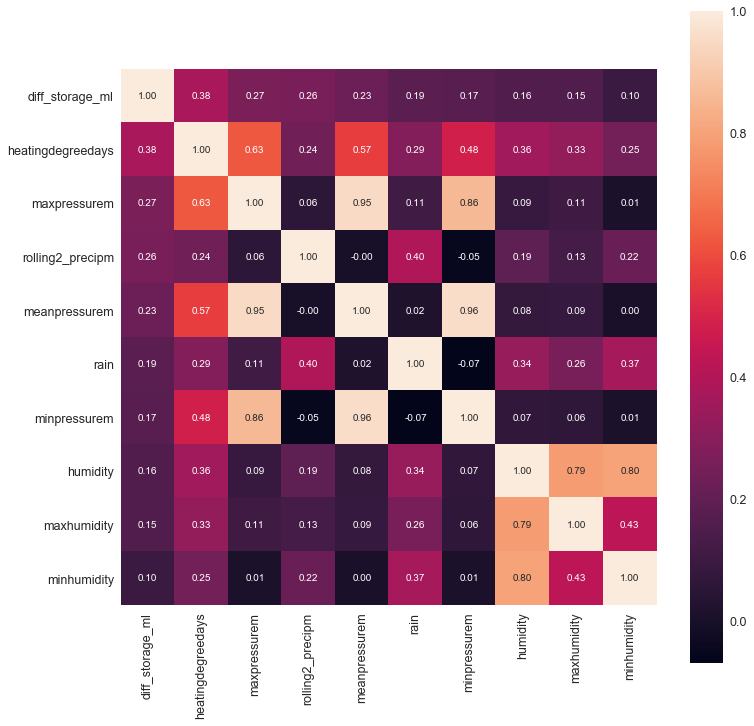

Index(['diff_storage_ml', 'meantempm', 'gdegreedays', 'maxtempm', 'maxdewptm',
       'mintempm', 'meandewptm', 'mindewptm', 'coolingdegreedays', 'maxwspdm'],
      dtype='object')


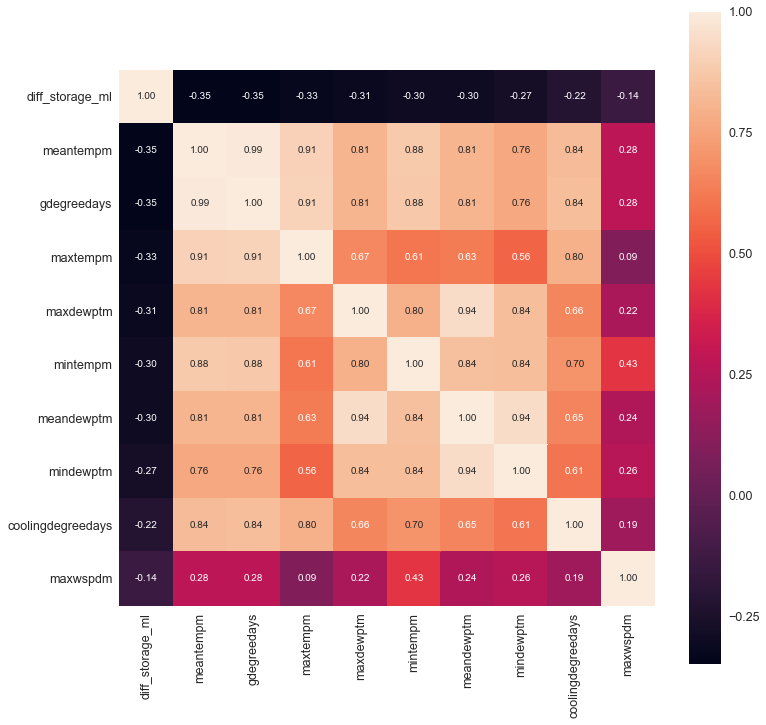

In [425]:
def filtered_heatmap(data, y, k = 10, largest = True):
    data = data.dropna(axis=0, how='any')
    corrmat = data.corr()
    if not largest:
        cols = corrmat.nsmallest(k, y)[y].index
    else:
        cols = corrmat.nlargest(k, y)[y].index
    if y not in cols:
        cols = cols.insert(0, 'diff_storage_ml')
    cm = np.corrcoef(data[cols].values.T)
    
    print(cols)
    fig = plt.figure(figsize = (12,12))
    sns.set(font_scale = 1.25)
    hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f',
                     annot_kws = {'size': 10}, yticklabels = cols.values, xticklabels = cols.values)
    plt.show()

filtered_heatmap(data.drop(['storage_ml'], axis = 1), 'diff_storage_ml', 10)
filtered_heatmap(data.drop(['storage_ml'], axis = 1), 'diff_storage_ml', 9, largest = False)

In [273]:
num_var = data.select_dtypes(include=[np.number]).columns
data_num = data[num_var]
data_num_long = pd.melt(data_num.reset_index(), id_vars = 'date')
data_num_long.head()

,date,variable,value
0,2012-01-01,height_m,24.83
1,2012-01-02,height_m,24.80
2,2012-01-03,height_m,24.77
3,2012-01-04,height_m,24.73
4,2012-01-05,height_m,24.67


C:\Users\jonathan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\jonathan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


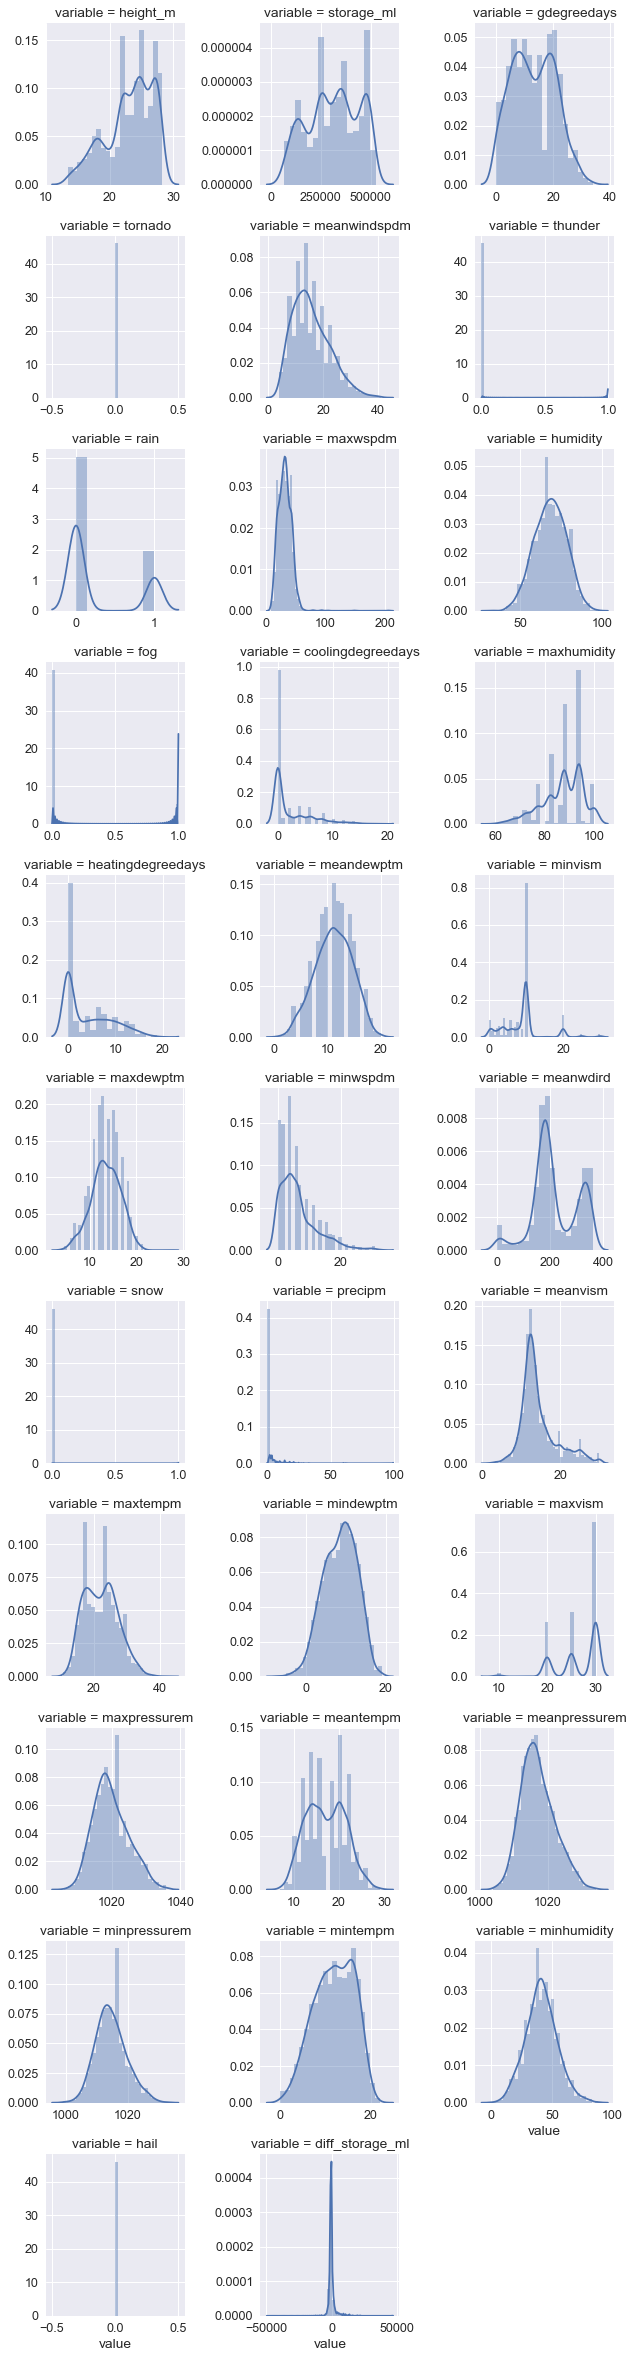

In [274]:
grid = sns.FacetGrid(data_num_long, col = "variable", col_wrap = 3, sharex = False, sharey = False)
grid = grid.map(sns.distplot, "value")

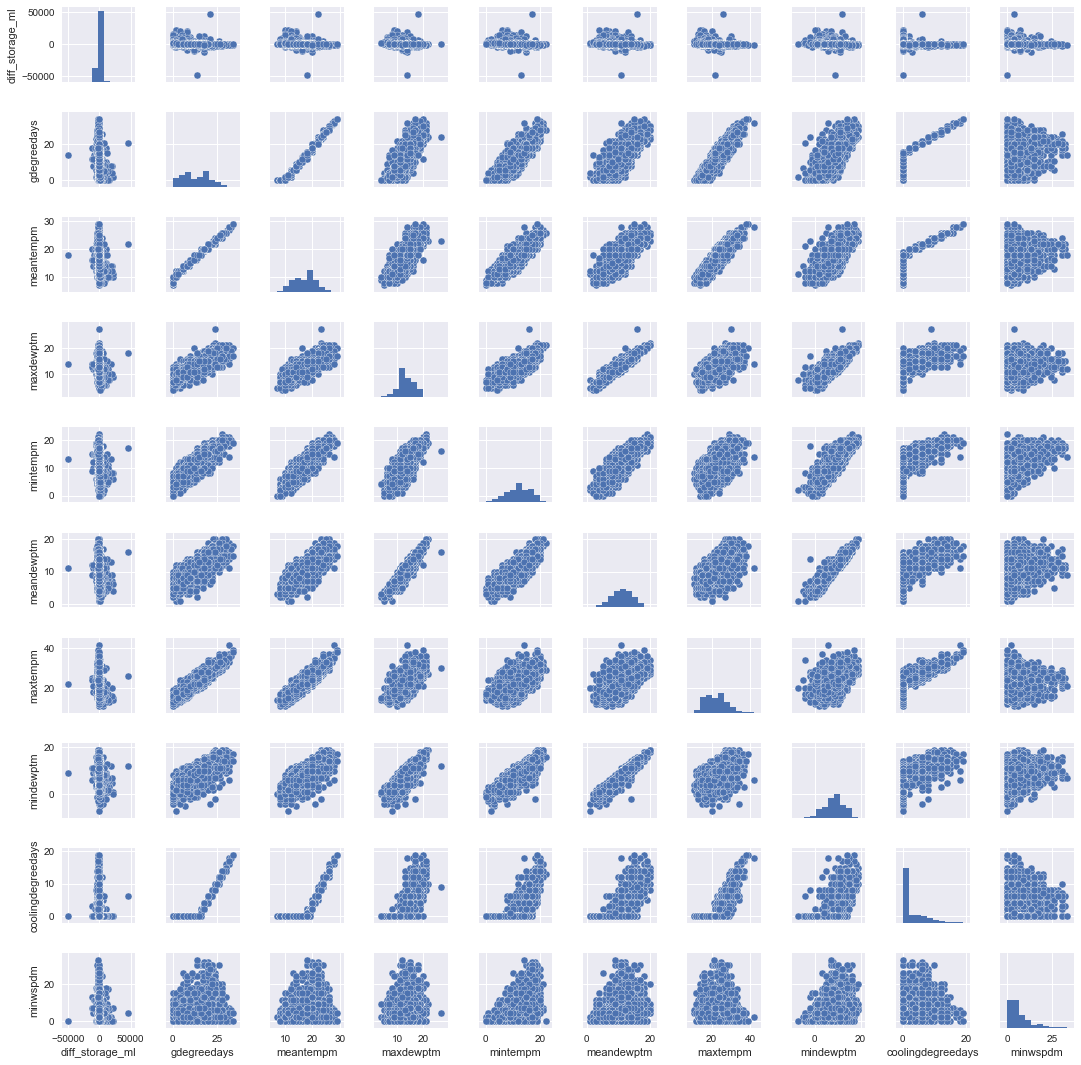

In [275]:
sns.set()  # Switches to seaborn defaults
sns.pairplot(data_num[['diff_storage_ml', 'gdegreedays', 'meantempm', 
                       'maxdewptm', 'mintempm', 'meandewptm', 'maxtempm', 
                       'mindewptm', 'coolingdegreedays', 'minwspdm']].dropna(axis=0, how='any'), size = 1.5)
plt.show()

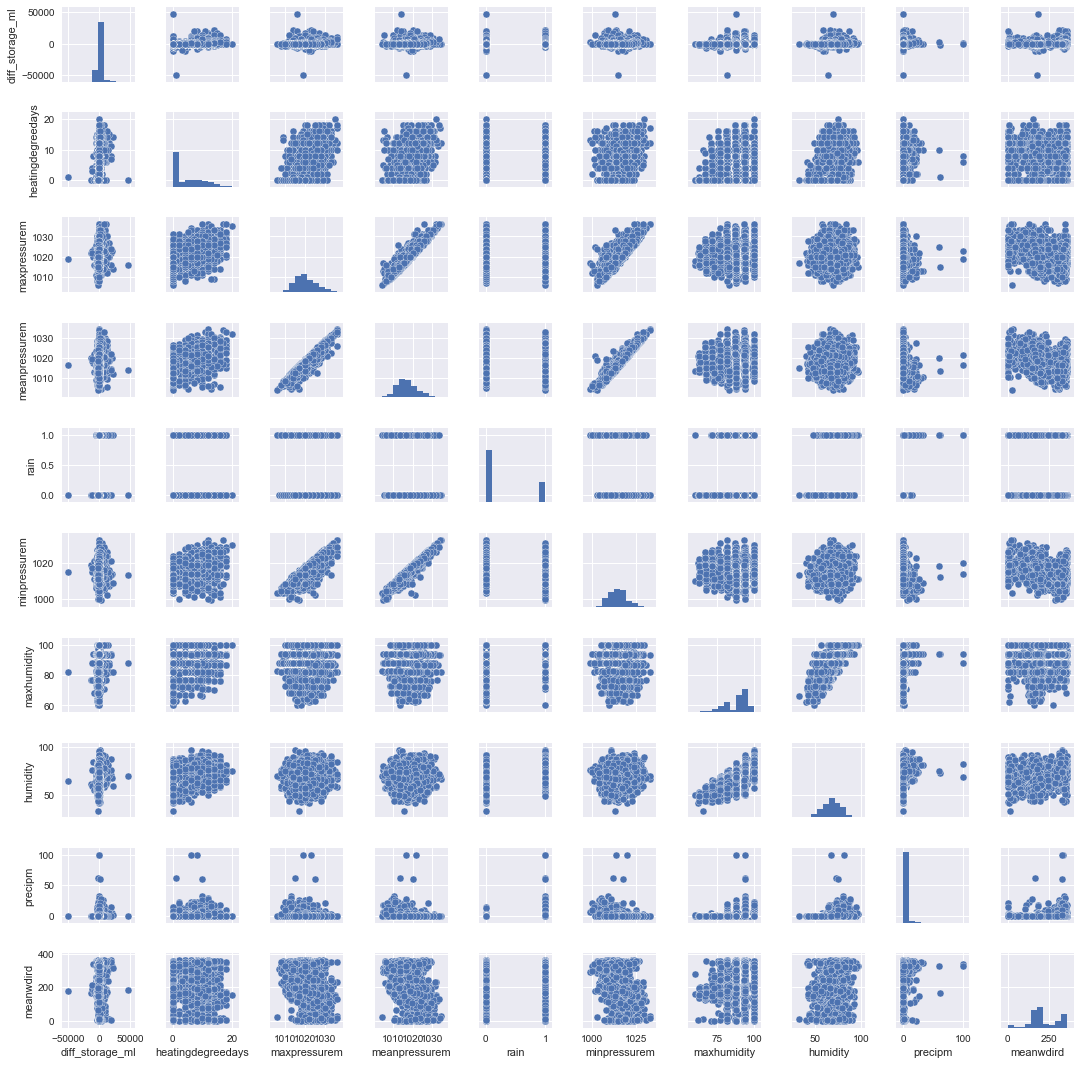

In [276]:
sns.set()  # Switches to seaborn defaults
sns.pairplot(data_num[['diff_storage_ml', 'heatingdegreedays', 'maxpressurem', 'meanpressurem',
                      'rain', 'minpressurem', 'maxhumidity', 'humidity', 'precipm',
                      'meanwdird']].dropna(axis=0, how='any'), size = 1.5)
plt.show()

# Try simple xgboost model

In [451]:
window = {}
for i in range(10):
    window[i] = data['diff_storage_ml'].corr(data['precipm'].rolling(window = i).sum())
window

{0: nan,
 1: 0.080439997288198575,
 2: 0.25704129490001582,
 3: 0.30805907587082487,
 4: 0.32292569212963335,
 5: 0.312698951887801,
 6: 0.30139754121448381,
 7: 0.28291019711700632,
 8: 0.2824839415916407,
 9: 0.287144775109618}

In [452]:
data['rolling4_precipm'] = data['precipm'].rolling(window = 4).sum()

In [453]:
data['rolling4_precipm'].corr(data['diff_storage_ml'])

0.32292569212963329

Split data into training & test sets. Will do this based on date:
2012, 2014, 2016: train
2013, 2015, 2017: test

In [454]:
data = data.reset_index()
dtrain = data[data['date'].dt.year.isin([2012, 2014, 2016])].dropna(axis = 0, how = 'any')
dtest = data[data['date'].dt.year.isin([2013, 2015, 2017])].dropna(axis = 0, how = 'any')

In [416]:
dtrain.head()

,index,date,dam_name,height_m,storage_ml,gdegreedays,tornado,meanwindspdm,thunder,rain,...,meantempm,meanwdire,meanpressurem,minpressurem,precipsource,mintempm,minhumidity,hail,diff_storage_ml,rolling2_precipm
1,1,2012-01-02,Theewaterskloof,24.80,356677.0,18,0,19,0,1,...,20,NW,1013.54,1012.0,Precip6GroupSynop,16,61,0,-1286.0,0.2
2,2,2012-01-03,Theewaterskloof,24.77,355394.0,20,0,15,0,1,...,20,NW,1015.06,1014.0,Precip6GroupSynop,15,31,0,-1283.0,0.2
3,3,2012-01-04,Theewaterskloof,24.73,353687.0,15,0,9,0,0,...,18,WSW,1015.91,1014.0,3Or6HourObs,11,30,0,-1707.0,0.0
4,4,2012-01-05,Theewaterskloof,24.67,351135.0,21,0,22,0,0,...,22,South,1017.22,1016.0,3Or6HourObs,18,39,0,-2552.0,0.0
5,5,2012-01-06,Theewaterskloof,24.64,349863.0,24,0,21,0,0,...,23,South,1016.94,1016.0,3Or6HourObs,18,14,0,-1272.0,0.0


In [301]:
def error(actual, predicted, log = True):
    if log:
        actual = np.log(actual)
        predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual - predicted))/len(actual))

In [455]:
num_var = data.select_dtypes(include=[np.number]).columns
num_var = num_var.drop('diff_storage_ml')

In [456]:
import sklearn.linear_model as linear_model

ridge = linear_model.RidgeCV(normalize = True)

x_train = dtrain[num_var]
y_train = dtrain['diff_storage_ml']
ridge.fit(x_train, y_train)

ypred_train = ridge.predict(x_train)
print(error(y_train, ypred_train, log = False))

x_test = dtest.drop('diff_storage_ml', axis = 1)[num_var]

ypred_ridge = ridge.predict(x_test)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=False)

2825.49873823


In [457]:
dtrain['diff_storage_ml'].mean()

error(dtest['diff_storage_ml'], -57.42, log = False)

-55.1643709825528

2352.0031678385194

In [422]:
y_actual_vs_pred['pred'].corr(y_actual_vs_pred['actual'])

0.42138588995837811

In [396]:
dtest['diff_storage_ml'].head()

366    -949.0
367    -948.0
368       0.0
369   -3309.0
370    -943.0
Name: diff_storage_ml, dtype: float64

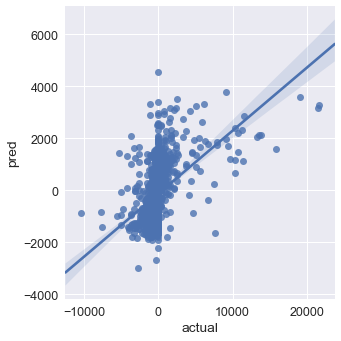

In [458]:
y_actual_vs_pred = pd.DataFrame({'actual': dtest['diff_storage_ml'],
                                 'pred': ypred_ridge})
# fig = plt.figure(figsize = (30,30))
sns.lmplot('actual', 'pred', y_actual_vs_pred)

In [401]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(4)
poly = poly.fit_transform(dtrain[num_var])

In [ ]:
pd.options.display.float_format = '{:,.2g}'.format


In [379]:
from xgboost.sklearn import XGBClassifier


C:\Users\jonathan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


OSError: [WinError 126] The specified module could not be found

In [282]:
import xgboost as xgb

dtrain = data.loc[data['date'].dt.year in (2012, 2014, 2016)]
dtest = data.loc[data['date'].dt.year in (2013, 2015, 2017)]

dtrain = xgb.DMatrix(dtrain)
dtest = xgb.DMatrix(dtest)

# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

ImportError: No module named 'xgboost'

#

In [126]:
def multi_plots(df):
    ncols = len(df.columns)
    fig = plt.figure(figsize = (10, ncols * 5))

    for idx, col in enumerate(df.columns):
        ax = fig.add_subplot(ncols, 1, idx + 1)
        ax.set_title(col)
        ax.plot(df[col])
    plt.show();

In [ ]:
fig = plt.figure(figsize = (15,15) )
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(theewaterskloof['diff_storage_ml'])
ax2.plot(theewaterskloof['precipm'])
ax3.plot(theewaterskloof['rolling3_lead1_precipm'])
#ax1.plot(theewaterskloof['precipm'])

In [ ]:
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, theewaterskloof.index, theewaterskloof['storage_ml'], theewaterskloof['rolling3_lead1_precipm'], 'r', 'b')


In [ ]:
theewaterskloof['storage_ml'].corr(theewaterskloof['precipm'])
plt.scatter(theewaterskloof['storage_ml'],theewaterskloof['precipm'])
plt.ylim([0,20])

In [ ]:
theewaterskloof['diff_storage_ml'].corr(theewaterskloof['precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof['diff_storage_ml'],theewaterskloof['precipm'])

In [ ]:
theewaterskloof['diff_storage_ml'] = theewaterskloof['storage_ml'].diff(periods = 1)
theewaterskloof['lead1_precipm'] = theewaterskloof['precipm'].shift(periods = 1)
theewaterskloof['lead2_precipm'] = theewaterskloof['precipm'].shift(periods = 2)
theewaterskloof['lead3_precipm'] = theewaterskloof['precipm'].shift(periods = 3)
theewaterskloof['rolling2_lead1_precipm'] = theewaterskloof['lead1_precipm'].rolling(window = 2).sum()
theewaterskloof['rolling2_precipm'] = theewaterskloof['precipm'].rolling(window = 2).sum()


In [ ]:
theewaterskloof['diff_storage_ml'].corr(theewaterskloof['rolling2_lead1_precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof['diff_storage_ml'],theewaterskloof['rolling2_lead1_precipm'])

In [ ]:
theewaterskloof['month'] = theewaterskloof['date'].dt.month
theewaterskloof_winter = theewaterskloof.loc[(theewaterskloof['month'] >= 6) &
                                            (theewaterskloof['month'] < 10) &
                                            (theewaterskloof['diff_storage_ml'] > 0)]
theewaterskloof_winter['diff_storage_ml'].corr(theewaterskloof_winter['rolling2_lead1_precipm'])
plt.figure(figsize = (10, 7))
plt.scatter(theewaterskloof_winter['diff_storage_ml'],theewaterskloof_winter['rolling2_lead1_precipm'])

In [ ]:
theewaterskloof_winter['precipm'].hist(bins = 30)